In [1]:
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("Daily_all.csv", index_col = "date")

In [3]:
test_size = 30
split_point = int(df.shape[0]-test_size)

In [4]:
df_train = df.iloc[0:split_point,:]
df_test = df.iloc[(split_point):df.shape[0],:]

In [5]:
df_train.tail(1)

,quantity
date,
2021-12-14,5898


In [6]:
df_test.head(1)

,quantity
date,
2021-12-15,5845


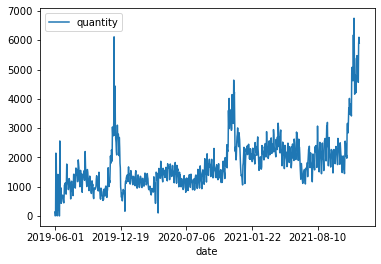

In [7]:
df_train.plot();

In [8]:
df_prophet = df_train.reset_index(drop=False)
df_prophet.columns = ["ds", "y"]

In [9]:
df_prophet.tail(5)

,ds,y
922,2021-12-10,4969
923,2021-12-11,4562
924,2021-12-12,5877
925,2021-12-13,6103
926,2021-12-14,5898


### Fitting baseline model

In [10]:
model = Prophet(n_changepoints=16, seasonality_mode = "additive", changepoint_prior_scale=0.05, seasonality_prior_scale=10.0, daily_seasonality = False)
model.fit(df_prophet)

In [11]:
future = model.make_future_dataframe(periods=30, include_history=False)

In [12]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-12-15,3641.956725,3170.204802,4154.982873
1,2021-12-16,3427.231339,2935.718053,3938.449264
2,2021-12-17,3260.783304,2752.393932,3735.204923
3,2021-12-18,2984.630419,2520.248494,3454.891408
4,2021-12-19,3346.944241,2869.957198,3854.867326
5,2021-12-20,3368.886146,2867.126821,3843.129431
6,2021-12-21,3140.302604,2643.848778,3621.233054
7,2021-12-22,3002.590193,2546.282433,3512.449139
8,2021-12-23,2841.632452,2373.543255,3311.303645
9,2021-12-24,2734.349777,2229.656036,3198.566324


In [13]:
# Forecast
Forecast = pd.Series(forecast.yhat.values, index=df_test.index)
lower_series = pd.Series(forecast.yhat_lower.values, index=df_test.index)
upper_series = pd.Series(forecast.yhat_upper.values, index=df_test.index)

In [14]:
Forecast.head(1)

date
2021-12-15    3641.956725
dtype: float64

In [15]:
df_test.head(1)

,quantity
date,
2021-12-15,5845


In [16]:
mean_absolute_percentage_error(df_test.quantity, Forecast)

0.2609444587323481

In [17]:
mean_absolute_error(df_test.quantity, Forecast)

581.0338115986353

In [18]:
mean_squared_error(df_test.quantity, Forecast)

549137.8902914325

### Cross-validation

In [19]:
df_prophet = df.reset_index(drop=False) #No split required here, the k-fold will split it automatically
df_prophet.columns = ["ds", "y"]
df_prophet.shape

(957, 2)

In [20]:
model = Prophet(n_changepoints=16, seasonality_mode = "additive", changepoint_prior_scale=0.05, seasonality_prior_scale=10.0, daily_seasonality = False)
model.fit(df_prophet)

In [21]:
df_cv=cross_validation(model, horizon='30 days', initial = '927 days' ) #This evaluates how the model using the last 30 days like the one I did manually above

INFO:prophet:Making 1 forecasts with cutoffs between 2021-12-14 00:00:00 and 2021-12-14 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-12-15,3641.956725,3159.365454,4136.986236,5845,2021-12-14
1,2021-12-16,3427.231339,2923.202056,3918.290963,4137,2021-12-14
2,2021-12-17,3260.783304,2752.921077,3726.824935,3100,2021-12-14
3,2021-12-18,2984.630419,2559.603368,3490.315540,2453,2021-12-14
4,2021-12-19,3346.944241,2867.076526,3831.168853,2631,2021-12-14


In [23]:
performance_metrics(df_cv, rolling_window=1) 

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,549137.890291,741.038387,581.033812,0.260944,0.160632,0.215068,0.533333


This should be comparable to LSTM, which evaluates the model with new data on each step

In [24]:
df_cv=cross_validation(model, horizon='1 days', initial = '927 days', period = "1 days" )
performance_metrics(df_cv, rolling_window=1)


INFO:prophet:Making 30 forecasts with cutoffs between 2021-12-14 00:00:00 and 2022-01-12 00:00:00


  0%|          | 0/30 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,450744.805408,671.375309,459.533639,0.208942,0.089451,0.173195,0.666667


All metrics were a lot lower on Prophet than with LSTM. This would probably change if data from external sources like weather, social midia are added as features to LSTM.

### Hyperparameter tunning

In [25]:
# Prophet: https://facebook.github.io/prophet/docs/diagnostics.html
param_grid = {'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'seasonality_prior_scale': [1.0, 10.0, 100.0],
              'seasonality_mode': ['additive', 'multiplicative']}

In [26]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store mapes


In [27]:
# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df_prophet)
    df_cv = cross_validation(model, horizon='30 days', initial = '927 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-12-14 00:00:00 and 2021-12-14 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f132c01bc70>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-12-14 00:00:00 and 2021-12-14 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12ddcc1fd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-12-14 00:00:00 and 2021-12-14 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12e2be8580>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seaso

In [28]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
0,0.01,1.0,additive,0.162480
1,0.01,1.0,multiplicative,0.161605
2,0.01,10.0,additive,0.162034
3,0.01,10.0,multiplicative,0.163978
4,0.01,100.0,additive,0.162791
5,0.01,100.0,multiplicative,0.162937
6,0.05,1.0,additive,0.265810
7,0.05,1.0,multiplicative,0.175770
8,0.05,10.0,additive,0.275957
9,0.05,10.0,multiplicative,0.174996


In [29]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


### Best model fit

In [30]:
df_prophet = df_train.reset_index(drop=False)
df_prophet.columns = ["ds", "y"]

In [31]:
model = Prophet(**best_params).fit(df_prophet)  # Fit model with given params

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = model.make_future_dataframe(periods=30, include_history=False)

In [33]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2022-01-09,2952.897988,2449.439837,3450.768490
26,2022-01-10,3146.079202,2611.639033,3658.713489
27,2022-01-11,2971.344388,2511.476518,3446.655523
28,2022-01-12,2916.761238,2394.738988,3439.378041
29,2022-01-13,2808.974929,2288.941823,3283.848966


In [34]:
# Forecast
Forecast = pd.Series(forecast.yhat.values, index=df_test.index)
lower_series = pd.Series(forecast.yhat_lower.values, index=df_test.index)
upper_series = pd.Series(forecast.yhat_upper.values, index=df_test.index)

(array([18017., 18140., 18262., 18383., 18506., 18628., 18748., 18871.,
        18993.]),
 [Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

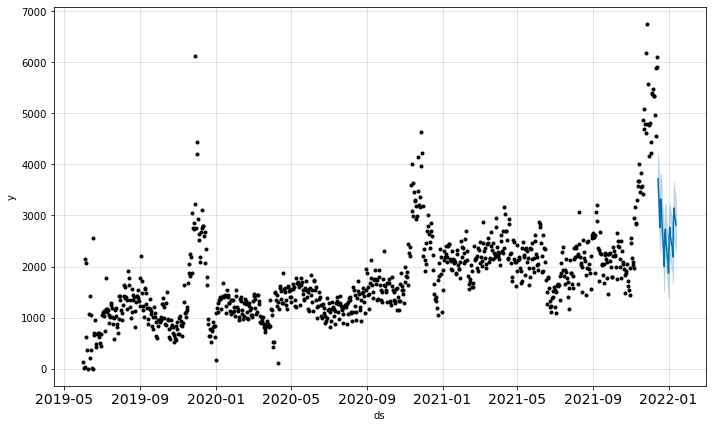

In [35]:
fig1 = model.plot(forecast)
plt.xticks(fontsize=14)

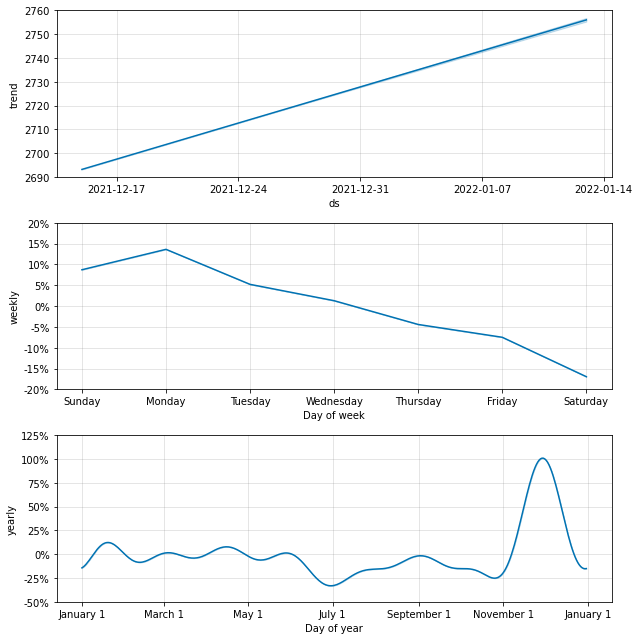

In [36]:
model.plot_components(forecast)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

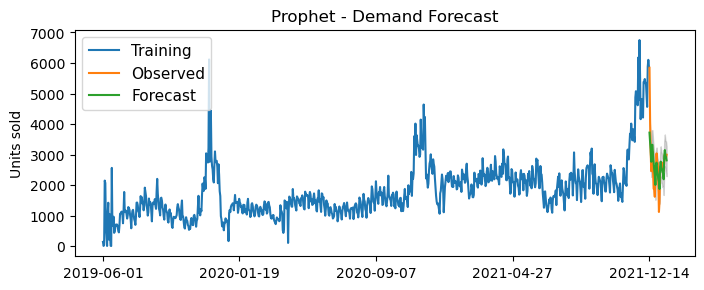

In [37]:
# Plot

n = len(df_train)
ticks = [0,int(n/4), int((n*2)/4), int((n*3)/4), n-1]
labels = list(df_train.iloc[ticks].index)

plt.figure(figsize=(8,3), dpi=100)
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Observed')

plt.plot(Forecast, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.xticks(ticks, labels)

plt.ylabel('Units sold')
plt.title('Prophet - Demand Forecast')
plt.legend(loc='upper left', fontsize=11)
plt.show()

Much better predictions with Prophet than ARIMA

In [38]:
mean_absolute_percentage_error(df_test, Forecast)

0.16160527469338906

In [39]:
mean_absolute_error(df_test, Forecast)

381.6776944939047

In [40]:
mean_squared_error(df_test, Forecast)

318376.05885196297